<h1><i><b>Analysis of CODE2</b></i></h3>
<i>

---

**Target:**
1.   **Restructuring the architecture** with Conv block and transition blocks.
2.   Make model bit light on trainable parameters as the data is MNIST which is very small.


**Results:**
1.   Parameters: 54416
2.   Best Train Acc: 99.46
3.   Best Test Acc: 98.99
4.   Difference : 0.47
5.   Epoch - 15


**Analysis:**
1.   Model still overfits with huge gap. Need to introduce regularization.
2.   The model is less complex with reduction in kernel values.
3.   After reducing the intermediate kernel values, model still is performing good.


---



**RECEPTIVE FIELD Calculation**


```
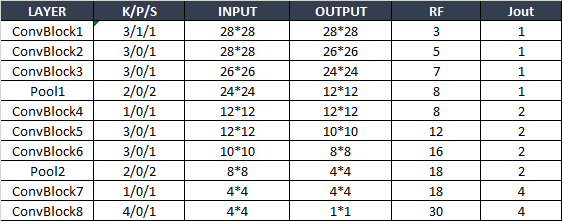

**IMPORTS**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

**DEFINE TEST/TRAIN TRANSFORMATIONS**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**LOAD MNIST DATA**

In [0]:
train = datasets.MNIST('./data', train=True, transform=train_transforms, download=True)
test = datasets.MNIST('./data',train=False, transform=test_transforms, download=True)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


**DATA LOADERS**

In [0]:
SEED = 1
np.random.seed(42)
torch.manual_seed(1)

#check for cuda
cuda = torch.cuda.is_available()
print('cuda available', cuda)

if cuda:
  torch.cuda.manual_seed(1)

#dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

cuda available True


**Data Stats**

In [0]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


**MODEL**

In [0]:
class Net(nn.Module):
     def __init__(self):
       super(Net, self).__init__()
       #Input block
       self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()
       ) # output_size = 28

       #CONV BLOCK 1
       self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
       ) # output_size = 26

       self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU()  
       ) #output size = 24
      
       #TRANSITION BLOCK
       self.pool1 = nn.MaxPool2d((2,2))  #out = 12
       self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1,1),padding=0, bias=False),
            nn.ReLU()
       ) #output = 12

       #CONV BLOCK 2
       self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
       ) # output_size = 10

       self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=0, bias=False),
            nn.ReLU()  
       ) #out = 8
       
       self.pool2 = nn.MaxPool2d((2,2))  #out = 4

      #  self.convblock7 = nn.Sequential(
      #       nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), padding=0, bias=False),
      #       nn.ReLU()  
      #  ) #out = 6
    
       #OUTPUT BLOCK

       self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1,1), padding=0, bias=False),
            nn.ReLU()  
       ) #out = 4

       self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(4,4), padding=0, bias=False),
            #nn.ReLU()  
       ) #out = 1


     def forward(self, x):
       x = self.convblock1(x)
       x = self.convblock2(x)
       x = self.convblock3(x)
       x = self.pool1(x)
       x = self.convblock4(x)
       x = self.convblock5(x)
       x = self.convblock6(x)
       x = self.pool2(x)
       x = self.convblock7(x)
       x = self.convblock8(x)
       x = x.view(-1, 10)
       return F.log_softmax(x, dim=-1)

**RF Calculation**

```
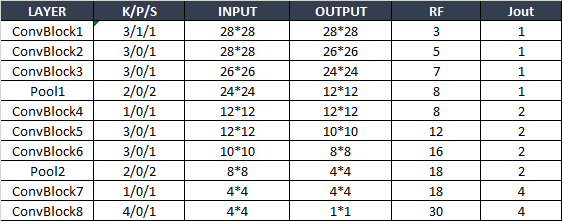

In [0]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
              ReLU-2           [-1, 16, 28, 28]               0
            Conv2d-3           [-1, 32, 26, 26]           4,608
              ReLU-4           [-1, 32, 26, 26]               0
            Conv2d-5           [-1, 64, 24, 24]          18,432
              ReLU-6           [-1, 64, 24, 24]               0
         MaxPool2d-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 16, 12, 12]           1,024
              ReLU-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 32, 10, 10]           4,608
             ReLU-11           [-1, 32, 10, 10]               0
           Conv2d-12             [-1, 64, 8, 8]          18,432
             ReLU-13             [-1, 64, 8, 8]               0
        MaxPool2d-14             [

**Define Train/Test functions with loss and accuracy calculations**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**Training the MODEL with validation accuracy check**

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.19279766082763672 Batch_id=937 Accuracy=46.34: 100%|██████████| 938/938 [00:16<00:00, 56.80it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.1606, Accuracy: 9474/10000 (94.74%)

EPOCH: 1


Loss=0.1364656686782837 Batch_id=937 Accuracy=96.14: 100%|██████████| 938/938 [00:15<00:00, 59.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9768/10000 (97.68%)

EPOCH: 2


Loss=0.0030327141284942627 Batch_id=937 Accuracy=97.79: 100%|██████████| 938/938 [00:16<00:00, 57.01it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9841/10000 (98.41%)

EPOCH: 3


Loss=0.006420791149139404 Batch_id=937 Accuracy=98.30: 100%|██████████| 938/938 [00:17<00:00, 53.16it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


Loss=0.01525406539440155 Batch_id=937 Accuracy=98.52: 100%|██████████| 938/938 [00:16<00:00, 56.34it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0430, Accuracy: 9860/10000 (98.60%)

EPOCH: 5


Loss=0.002103567123413086 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [00:16<00:00, 58.12it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0360, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.0009484291076660156 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [00:17<00:00, 54.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9888/10000 (98.88%)

EPOCH: 7


Loss=0.0017011761665344238 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [00:17<00:00, 54.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9882/10000 (98.82%)

EPOCH: 8


Loss=0.09887494146823883 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [00:16<00:00, 55.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9886/10000 (98.86%)

EPOCH: 9


Loss=0.0018692314624786377 Batch_id=937 Accuracy=99.25: 100%|██████████| 938/938 [00:17<00:00, 52.98it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9884/10000 (98.84%)

EPOCH: 10


Loss=0.10135260224342346 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:17<00:00, 60.92it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0348, Accuracy: 9889/10000 (98.89%)

EPOCH: 11


Loss=0.02549111843109131 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [00:17<00:00, 54.64it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9859/10000 (98.59%)

EPOCH: 12


Loss=0.019318103790283203 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:17<00:00, 54.71it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0319, Accuracy: 9908/10000 (99.08%)

EPOCH: 13


Loss=0.03550758957862854 Batch_id=937 Accuracy=99.40: 100%|██████████| 938/938 [00:17<00:00, 54.41it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9907/10000 (99.07%)

EPOCH: 14


Loss=0.0018534064292907715 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:16<00:00, 56.38it/s]



Test set: Average loss: 0.0334, Accuracy: 9899/10000 (98.99%)



Text(0.5, 1.0, 'Test Accuracy')

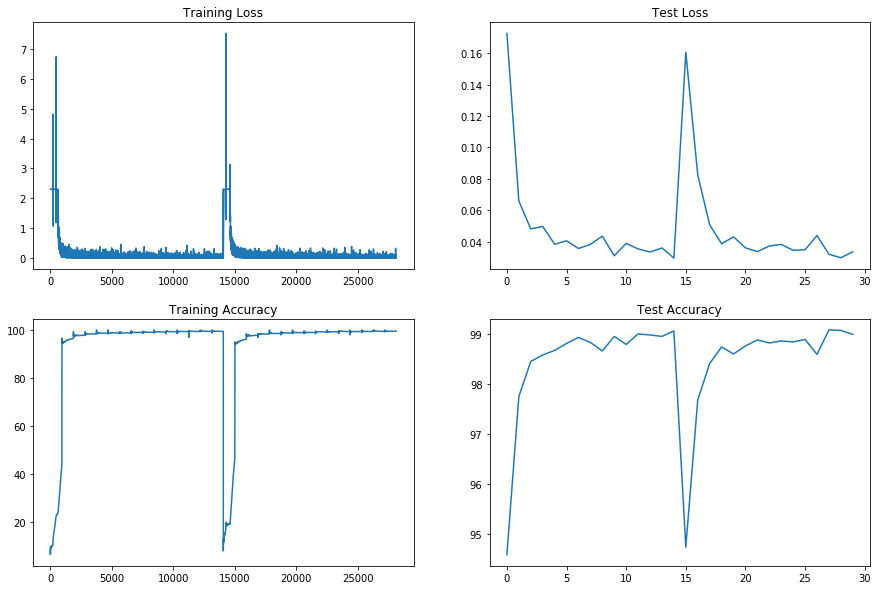

In [0]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")